In [1]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from common.functions import *
from common.gradient import numerical_gradient
from dataset.mnist import load_mnist


In [2]:
# 2층 weight 신경망
class TwoLayerNet:
    
    #입력층 노드 수(0층) , 은닉층(1층) 노드 수, 출력층(2층) 노드 수
    # 초기 weight와 bias는 랜덤.
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        # W1은 1층 무게 W2는 2층무게
        # b는 각층 bias
        self.params = {}
        # 0층 노두수 *1층 노드 수 행렬 
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        # 1* 1층 노드 수 (1층 노드에서 더해질 bias)
        self.params['b1'] = np.zeros(hidden_size)
        # 1층 노두수 *2층 노드 수 행렬
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        # 1* 2층 노드 수  (2층 노드에서 더해질 bias)
        self.params['b2'] = np.zeros(output_size)

    # x 입력이 들어올떄 예측 출력값.
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        #1층에서 w와 b계산후 sigmoid
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        #2층에서 w와 b계산후 sigmoid
        a2 = np.dot(z1, W2) + b2
        
        #마지막 결과 값 softmax로 확률화..
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        #loss의 오차 구하는 값,,
        # x입력이 주어졌을때 예측한 y값과 정답 t의 차이 반환!
        return cross_entropy_error(y, t)
    
    #입력 x 정답 t일때 정확도 계산
    def accuracy(self, x, t):
        y = self.predict(x)
        # 각 행별로 가장큰 열이 있는 인덱스를 반환하는 배열
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        #각 행 => testcase_ 각 testcase마다 가장 큰게 같다면, 맞춘 testcase 개수가 분자
        # x의 1차원(즉 행의수)는 전제 testcase의 숫자...
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        #x입력값 t 정답일때 현재 weight로 계산한 loss값
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        #weight 와 bias의 각각의 편미분 값을 구한 행렬 반환,
        #numerical_gradient함수는 각 weight에 대한 편미분을 하나씩 loss_W값을 확인하며 구한다.
        #느린듯..
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    #이건 뭐하는 함수지?? 최적화 하였따 위의 함수가 느려서..
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        #batch는 총 task 수
        batch_num = x.shape[0]

        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num            #task수만큼 차이를 나눈다? 
        grads['W2'] = np.dot(z1.T, dy)      #W2의 기울기는 z1에서 각 dy의 행렬곱?
        grads['b2'] = np.sum(dy, axis=0)    #b2의 기울기는 dy의 각 test들의 노드별 합
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [3]:
# 데이터 읽기
# train , test
# 시험할것, 정답
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)


In [4]:
# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []


In [5]:
# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    #print('\n',i,"진행중!\n")
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    #print("기울기끝!\n")
    
    # 매개변수 갱신
    # 기울기 만큼 빼준다..
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))


train acc, test acc | 0.09751666666666667, 0.0974
train acc, test acc | 0.7838, 0.7905
train acc, test acc | 0.8765833333333334, 0.8803
train acc, test acc | 0.8968, 0.9003
train acc, test acc | 0.9077666666666667, 0.9091
train acc, test acc | 0.9141666666666667, 0.9142
train acc, test acc | 0.9201, 0.9212
train acc, test acc | 0.9242666666666667, 0.9236
train acc, test acc | 0.9280166666666667, 0.9273
train acc, test acc | 0.9320166666666667, 0.9322
train acc, test acc | 0.9343666666666667, 0.9332
train acc, test acc | 0.93645, 0.936
train acc, test acc | 0.93905, 0.9377
train acc, test acc | 0.9419166666666666, 0.9407
train acc, test acc | 0.9435, 0.9416
train acc, test acc | 0.9459833333333333, 0.9426
train acc, test acc | 0.9473, 0.9445


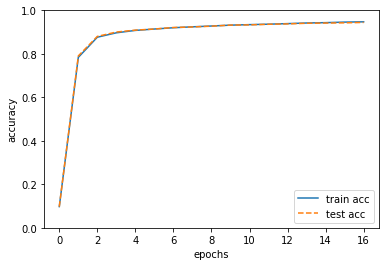

In [6]:
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()